In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd

## Load susbset of data

In [2]:
from splicevo.data import MultiGenomeDataLoader

loader = MultiGenomeDataLoader()

# Load genome and gene annotation
human_chromosomes = ['20', '21']
loader.add_genome(
    genome_id="human_GRCh37",
    genome_path="/home/elek/sds/sd17d003/Anamaria/genomes/mazin/fasta/Homo_sapiens.fa.gz", 
    gtf_path="/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz",
    chromosomes=human_chromosomes,
    metadata={"species": "homo_sapiens", "assembly": "GRCh37"}
)

# Load tissue-specific splice site usage
for tissue in ["Brain"]:
    for timepoint_int in range(0, 5):
        try:
            timepoint = str(timepoint_int)
            loader.add_usage_file(
                genome_id="human_GRCh37", 
                usage_file=f"/home/elek/projects/splicing/results/spliser/Homo_sapiens/Human.{tissue}.{timepoint}.combined.tsv",
                tissue=tissue,
                timepoint=timepoint
            )
        except FileNotFoundError as e:
            pass

# Show available conditions
conditions_df = loader.get_available_conditions()
conditions_df

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading usage file for human_GRCh37 - Brain 1: /home/elek/projects/splicing/results/spliser/Homo_sapiens/Human.Brain.1.combined.tsv
Removed 1366 duplicate entries
Loaded 580739 usage entries for Brain 1
Loading usage file for human_GRCh37 - Brain 4: /home/elek/projects/splicing/results/spliser/Homo_sapiens/Human.Brain.4.combined.tsv
Removed 1561 duplicate entries
Loaded 611728 usage entries for Brain 4


,condition_key,tissue,timepoint,display_name
0,Brain_1,Brain,1,Brain 1
1,Brain_4,Brain,4,Brain 4


In [3]:
# Load genome data
loader.load_all_genomes_data()

# Get summary of loaded data
summary = loader.get_summary()
summary

Processing GTF annotations for human_GRCh37...
Loading GTF file...
Loaded 146231 GTF records
Extracting transcripts...
Processing 133069 exon records from 13162 transcripts...
Created 13162 transcript objects


Processing transcripts: 100%|██████████| 14/14 [00:12<00:00,  1.10batch/s]


Collected 239814 positions (239814 positive)
Processing 239814 sequences...


Creating splice sites: 100%|██████████| 239814/239814 [00:00<00:00, 685876.39site/s]


Loaded 239814 examples
Total loaded examples: 239814


,genome_id,chromosome,site_type,n_sites
0,human_GRCh37,20,1,7712
1,human_GRCh37,20,2,7306
2,human_GRCh37,21,1,3282
3,human_GRCh37,21,2,3102


In [4]:
sequences, labels, usage_arrays, metadata = loader.to_arrays(
    window_size=1000,
    context_size=450,
    alpha_threshold=5,
    n_workers=8
)

Building splice site index...
Indexed 21400 splice sites
Processing genome human_GRCh37...
  Processing 1367 genes...
  Pre-loading genome...
  Using 8 parallel workers...


  human_GRCh37 genes: 100%|██████████| 1367/1367 [00:47<00:00, 28.48gene/s]


Converting to numpy arrays...
Applying alpha threshold: 5
  alpha: 18648119 NaN values, 18665444 non-zero values
  beta: 18648119 NaN values, 18662640 non-zero values
  sse: 18648119 NaN values, 18665444 non-zero values
Created 9337 windowed examples
  Sequence shape: (9337, 1900, 4)
  Labels shape: (9337, 1000)
  Usage arrays shape: (9337, 1000, 2)
  Total donor sites: 9956
  Total acceptor sites: 9458
  Total no-site positions: 9317586


In [6]:
print(f"Loaded usage info for {usage_arrays['sse'].shape[0]} windows and {usage_arrays['sse'].shape[2]} tissues/timepoints")

Loaded usage info for 9337 windows and 2 tissues/timepoints


In [8]:
print("Metadata for loaded windows:")
metadata

Metadata for loaded windows:


,genome_id,chromosome,gene_id,strand,window_start,window_end,n_donor_sites,n_acceptor_sites
0,human_GRCh37,20,hum.38565,+,138235,139235,1,0
1,human_GRCh37,20,hum.38566,+,123328,124328,3,0
2,human_GRCh37,20,hum.38567,-,168760,169760,0,1
3,human_GRCh37,20,hum.38569,+,207988,208988,1,0
4,human_GRCh37,20,hum.38570,+,238478,239478,1,0
...,...,...,...,...,...,...,...,...
9332,human_GRCh37,21,hum.41637,+,47858197,47859197,45,0
9333,human_GRCh37,21,hum.41637,+,47859197,47860197,45,45
9334,human_GRCh37,21,hum.41637,+,47860197,47861197,43,45
9335,human_GRCh37,21,hum.41637,+,47862197,47863197,23,42


In [10]:
usage_info = loader.get_usage_array_info(usage_arrays)
usage_info

{'n_samples': 9337,
 'n_conditions': 2,
 'conditions': [{'condition_key': 'Brain_1',
   'tissue': 'Brain',
   'timepoint': '1',
   'display_name': 'Brain 1'},
  {'condition_key': 'Brain_4',
   'tissue': 'Brain',
   'timepoint': '4',
   'display_name': 'Brain 4'}],
 'condition_coverage': {'Brain_1': {'tissue': 'Brain',
   'timepoint': '1',
   'display_name': 'Brain 1',
   'n_samples_with_data': 886,
   'coverage_fraction': 0.09489129270643676,
   'mean_sse': 0.4045361280441284,
   'mean_alpha': 36.93905258178711,
   'mean_beta': 4.147855758666992},
  'Brain_4': {'tissue': 'Brain',
   'timepoint': '4',
   'display_name': 'Brain 4',
   'n_samples_with_data': 20,
   'coverage_fraction': 0.002142015636714148,
   'mean_sse': 0.5965499877929688,
   'mean_alpha': 40.5,
   'mean_beta': 15.600000381469727}}}

## Load training and test data

In [2]:
from splicevo.utils.data_utils import load_processed_data
import json

data_dir = "/home/elek/projects/splicing/results/data_processing"

train_fn = "memmap_train"
train_path = os.path.join(data_dir, train_fn)
print(f"Loading training data {train_path}...")
train_sequences, train_labels, train_alpha, train_beta, train_sse = load_processed_data(train_path)

train_meta_fn = os.path.join(data_dir, "usage_info_train.json")
with open(train_meta_fn, "r") as f:
    train_meta = json.load(f)

test_fn = "memmap_test"
test_path = os.path.join(data_dir, test_fn)
print(f"Loading test data {test_path}...")
test_sequences, test_labels, test_alpha, test_beta, test_sse = load_processed_data(test_path)

test_meta_fn = os.path.join(data_dir, "usage_info_test.json")
with open(test_meta_fn, "r") as f:
    test_meta = json.load(f)

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading training data /home/elek/projects/splicing/results/data_processing/memmap_train...
Sequences shape: (208343, 1900, 4)
Labels shape: (208343, 1000)
SSE shape: (208343, 1000, 62)
Alpha shape: (208343, 1000, 62)
Beta shape: (208343, 1000, 62)
Loading test data /home/elek/projects/splicing/results/data_processing/memmap_test...
Sequences shape: (54043, 1900, 4)
Labels shape: (54043, 1000)
SSE shape: (54043, 1000, 62)
Alpha shape: (54043, 1000, 62)
Beta shape: (54043, 1000, 62)


Number of NaNs in train SSE: 9865986 (36.54%)


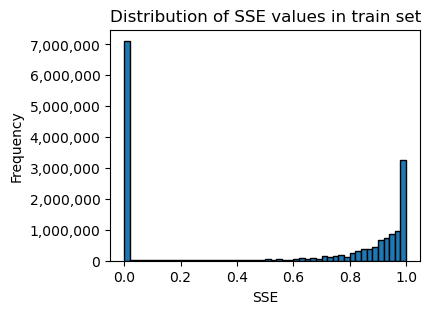

Number of zeros in train SSE: 7114255 (41.51%)
Number of ones in train SSE: 2725850 (15.91%)


{'count': 17136874,
 'mean': np.float32(0.51636404),
 'std': np.float32(0.4541375),
 'min': np.float32(0.0),
 '25%': np.float32(0.0),
 '50%': np.float32(0.765),
 '75%': np.float32(0.958),
 'max': np.float32(1.0)}

In [4]:
# distribution of SSE values
import numpy as np

# Splice mask
splice_mask = train_labels.flatten() > 0

# Apply mask to every column in train SSE
flat_sse = train_sse.reshape(-1, train_sse.shape[-1])[splice_mask]
    

# How many are NaNs?
num_nans = np.sum(np.isnan(flat_sse))
print(f"Number of NaNs in train SSE: {num_nans} ({num_nans / flat_sse.size * 100:.2f}%)")

# Remove NaNs for summary statistics
flat_sse = flat_sse[~np.isnan(flat_sse)]


# Plot distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3))
plt.hist(flat_sse, bins=50, edgecolor='black')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title("Distribution of SSE values in train set")
plt.xlabel("SSE")
plt.ylabel("Frequency")
plt.show()

# Number of zeros
num_zeros = np.sum(flat_sse == 0)
print(f"Number of zeros in train SSE: {num_zeros} ({num_zeros / flat_sse.size * 100:.2f}%)")

# Number of ones
num_ones = np.sum(flat_sse == 1)
print(f"Number of ones in train SSE: {num_ones} ({num_ones / flat_sse.size * 100:.2f}%)")

# Summary statistics
summary = {
	"count": flat_sse.size,
	"mean": np.mean(flat_sse),
	"std": np.std(flat_sse),
	"min": np.min(flat_sse),
	"25%": np.percentile(flat_sse, 25),
	"50%": np.percentile(flat_sse, 50),
	"75%": np.percentile(flat_sse, 75),
	"max": np.max(flat_sse)
}
summary

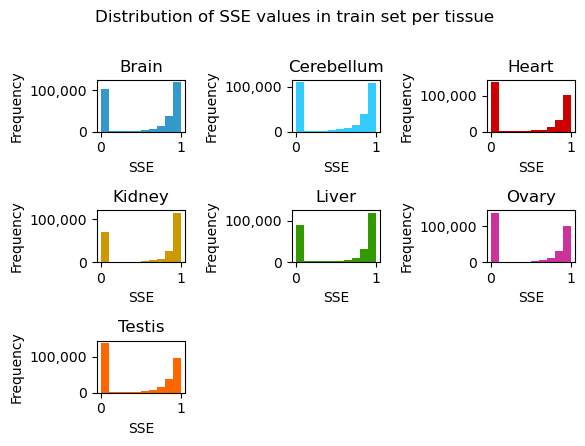

In [5]:
# Per tissue true SSE distribution
import pandas as pd
import matplotlib.pyplot as plt

# Get tissues in trian set
tissues = []
for cond in train_meta['conditions']:
    tiss = cond['tissue']
    if tiss not in tissues:
        tissues.append(tiss)

# Define tissue colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}

n_tissues = len(tissues)
n_cols = 3
n_rows = (n_tissues + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 1.5), squeeze=False)

for tiss_idx, tiss_name in enumerate(tissues):
    ax = axes[tiss_idx // n_cols, tiss_idx % n_cols]
    tiss_sse = train_sse[:, :, tiss_idx].flatten()
    tiss_sse = tiss_sse[train_labels.flatten() > 0]
    tiss_sse = tiss_sse[~np.isnan(tiss_sse)]
    ax.hist(tiss_sse, bins=10, color=tissue_colors.get(tiss_name, '#333333'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.set_title(f"{tiss_name}")
    ax.set_xlabel("SSE")
    ax.set_ylabel("Frequency")

# Hide unused subplots
for i in range(n_tissues, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols, i % n_cols])

fig.suptitle("Distribution of SSE values in train set per tissue")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## Load model predictions

In [6]:
# Load the model predictions
from splicevo.utils.data_utils import load_predictions
pred_path = "/home/elek/projects/splicing/results/predictions_resnet_weightmse"
pred_labels, pred_probs, pred_sse, meta, true_labels, true_sse = load_predictions(pred_path)

Loaded splice predictions shape: (54043, 1000)
Loaded splice probs shape: (54043, 1000, 3)
Loaded splice sse shape: (54043, 1000, 62)
Loaded true labels shape: (54043, 1000)
Loaded true sse shape: (54043, 1000, 62)


Number of NaNs in true SSE: 3346221312 (99.87%)


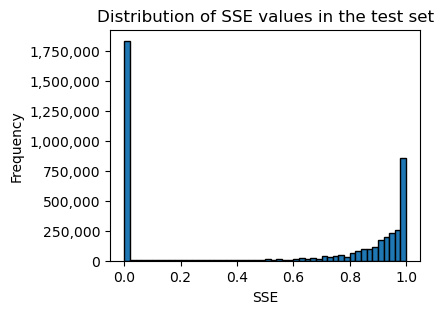

In [7]:
# Distribution of true SSE values in the test set
import numpy as np
# Flatten
flat_true_sse = true_sse.flatten()
# How many are NaNs?
num_nans_true = np.sum(np.isnan(flat_true_sse))
print(f"Number of NaNs in true SSE: {num_nans_true} ({num_nans_true / flat_true_sse.size * 100:.2f}%)")
# Remove NaNs for summary statistics
flat_true_sse = flat_true_sse[~np.isnan(flat_true_sse)]
# Plot distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3))
plt.hist(flat_true_sse, bins=50, edgecolor='black')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title("Distribution of SSE values in the test set")
plt.xlabel("SSE")
plt.ylabel("Frequency")
plt.show()

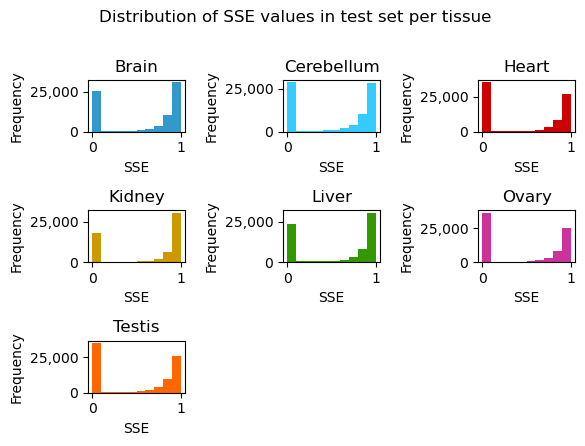

In [8]:
# Distribution of true SSE values in the test set per tissue
import pandas as pd
import matplotlib.pyplot as plt
# Get tissues in test set
tissues = []
for cond in meta['conditions']:
    tiss = cond['tissue']
    if tiss not in tissues:
        tissues.append(tiss)
        
n_tissues = len(tissues)
n_cols = 3
n_rows = (n_tissues + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 1.5), squeeze=False)

for tiss_idx, tiss_name in enumerate(tissues):
    ax = axes[tiss_idx // n_cols, tiss_idx % n_cols]
    tiss_sse = true_sse[:, :, tiss_idx].flatten()
    tiss_sse = tiss_sse[true_labels.flatten() > 0]
    tiss_sse = tiss_sse[~np.isnan(tiss_sse)]
    ax.hist(tiss_sse, bins=10, color=tissue_colors.get(tiss_name, '#333333'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.set_title(f"{tiss_name}")
    ax.set_xlabel("SSE")
    ax.set_ylabel("Frequency")

# Hide unused subplots
for i in range(n_tissues, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols, i % n_cols])

fig.suptitle("Distribution of SSE values in test set per tissue")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


Number of NaNs in predicted SSE: 0 (0.00%)


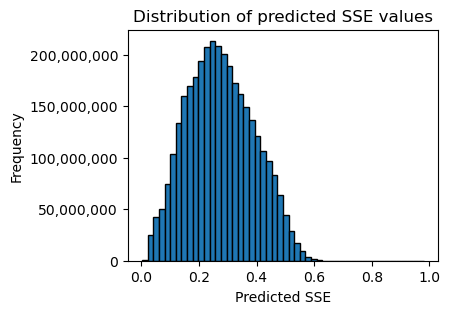

In [9]:
# Distribution of predicted SSE values
import numpy as np
# Flatten predicted SSE
flat_pred_sse = pred_sse.flatten()
# How many are NaNs?
num_nans_pred = np.sum(np.isnan(flat_pred_sse))
print(f"Number of NaNs in predicted SSE: {num_nans_pred} ({num_nans_pred / flat_pred_sse.size * 100:.2f}%)")
# Remove NaNs for summary statistics
flat_pred_sse = flat_pred_sse[~np.isnan(flat_pred_sse)]
# Plot distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3))
plt.hist(flat_pred_sse, bins=50, edgecolor='black')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title("Distribution of predicted SSE values")
plt.xlabel("Predicted SSE")
plt.ylabel("Frequency")
plt.show()

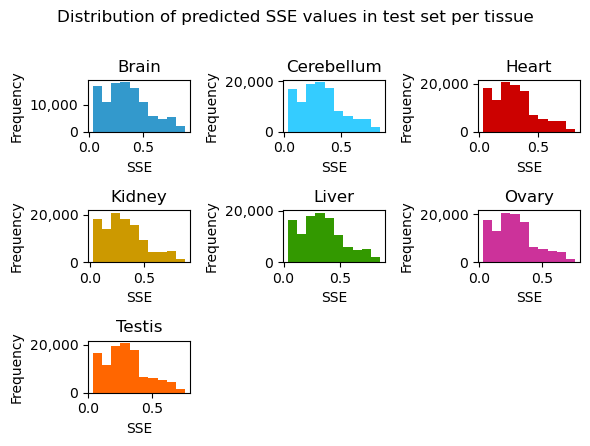

In [10]:
# Distribution of predicted SSE values in the test set per tissue
import pandas as pd
import matplotlib.pyplot as plt

# Get tissues in test set
tissues = []
for cond in meta['conditions']:
    tiss = cond['tissue']
    if tiss not in tissues:
        tissues.append(tiss)
        
n_tissues = len(tissues)
n_cols = 3
n_rows = (n_tissues + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 1.5), squeeze=False)

for tiss_idx, tiss_name in enumerate(tissues):
    ax = axes[tiss_idx // n_cols, tiss_idx % n_cols]
    tiss_sse = pred_sse[:, :, tiss_idx].flatten()
    tiss_sse = tiss_sse[true_labels.flatten() > 0]
    tiss_sse = tiss_sse[~np.isnan(tiss_sse)]
    ax.hist(tiss_sse, bins=10, color=tissue_colors.get(tiss_name, '#333333'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.set_title(f"{tiss_name}")
    ax.set_xlabel("SSE")
    ax.set_ylabel("Frequency")

# Hide unused subplots
for i in range(n_tissues, n_rows * n_cols):
    fig.delaxes(axes[i // n_cols, i % n_cols])

fig.suptitle("Distribution of predicted SSE values in test set per tissue")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [11]:
# For every sequence, identify positions that are not NaN in any of the samples, then compare values
num_sequences = true_sse.shape[0]
num_positions = true_sse.shape[1]
num_samples = true_sse.shape[2]

# Get all sample names
sample_names = []
for cond in meta['conditions']:
    sample_names.append(cond['condition_key'])

matched_positions = {}

for seq_idx in range(num_sequences):
    # Find positions where any/all tissues are not NaN for this sequence
    valid_positions = np.where(np.any(~np.isnan(true_sse[seq_idx, :, :]), axis=1))[0]
    if len(valid_positions) == 0:
        continue
    for pos in valid_positions:
        true_vals = true_sse[seq_idx, pos, :]
        pred_vals = pred_sse[seq_idx, pos, :]
        matched_positions[(seq_idx, pos)] = { "true": true_vals, "pred": pred_vals }

# Combine all matched positions into a single dataframe for plotting
import pandas as pd
all_data = []
for (seq_idx, pos), vals in matched_positions.items():
    for smpl_idx, smpl_name in enumerate(sample_names):
        all_data.append({
            'sequence': seq_idx,
            'position': pos,
            'group': smpl_name,
            'tissue': smpl_name.split('_')[0],
            'timepoint': smpl_name.split('_')[1],
            'true_SSE': vals['true'][smpl_idx],
            'pred_SSE': vals['pred'][smpl_idx]
        })  

all_data_df = pd.DataFrame(all_data)
all_data_df['site'] = all_data_df['sequence'].astype(str) + '_' + all_data_df['position'].astype(str)
all_data_df['tissue'] = all_data_df['group'].apply(lambda x: x.split('_')[0])
all_data_df['timepoint'] = all_data_df['group'].apply(lambda x: x.split('_')[1])
all_data_df = all_data_df.fillna(0)
all_data_df

,sequence,position,group,tissue,timepoint,true_SSE,pred_SSE,site
0,0,0,Brain_1,Brain,1,0.0,0.042462,0_0
1,0,0,Brain_4,Brain,4,0.0,0.044164,0_0
2,0,0,Brain_5,Brain,5,0.0,0.039307,0_0
3,0,0,Brain_7,Brain,7,0.0,0.045252,0_0
4,0,0,Brain_9,Brain,9,0.0,0.046859,0_0
...,...,...,...,...,...,...,...,...
6456489,54042,934,Testis_8,Testis,8,0.0,0.049349,54042_934
6456490,54042,934,Testis_9,Testis,9,0.0,0.056415,54042_934
6456491,54042,934,Testis_10,Testis,10,0.0,0.066865,54042_934
6456492,54042,934,Testis_14,Testis,14,0.0,0.125144,54042_934


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get tissues in test set
tissues = []
for cond in meta['conditions']:
    tiss = cond['tissue']
    if tiss not in tissues:
        tissues.append(tiss)
        
n_tissues = len(tissues)
n_cols = 3
n_rows = (n_tissues + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), squeeze=False)

for tiss_idx, tiss_name in enumerate(tissues):
    ax = axes[tiss_idx // n_cols, tiss_idx % n_cols]
    plot_data = all_data_df[all_data_df['tissue'] == tiss_name]

    # 2d density plot
    plot_col = tissue_colors.get(tiss_name, 'gray')
    plot_shade = sns.light_palette(plot_col, as_cmap=True)
    sns.kdeplot(
        x=plot_data['true_SSE'],
        y=plot_data['pred_SSE'],
        levels=10,
        fill = True,
        cmap=plot_shade,
        ax=ax
    )

    # Top histogram (True SSE)
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
    ax_histx.hist(
        plot_data['true_SSE'],
        bins=30,
        color=tissue_colors.get(tissue, 'gray'),
        alpha=0.7
    )
    # Remove x ticks; keep y axis visible
    ax_histx.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

    # Right histogram (Pred SSE)
    ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
    ax_histy.hist(
        plot_data['pred_SSE'],
        bins=30,
        orientation='horizontal',
        color=tissue_colors.get(tissue, 'gray'),
        alpha=0.7
    )

    # Add mean lines
    mean_true = plot_data['true_SSE'].mean()
    mean_pred = plot_data['pred_SSE'].mean()
    ax.axvline(mean_true, color='red', linestyle='--', linewidth=1, label='Mean True')
    ax.axhline(mean_pred, color='red', linestyle='--', linewidth=1, label='Mean Pred')
    
    # Remove y ticks; keep x axis visible
    ax_histy.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)

    # Rotate x labels of right histogram and scatterplot
    plt.setp(ax_histy.get_xticklabels(), rotation=90, ha='center')
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')

    # Remove all axis labels from histograms
    ax_histy.set_xlabel('')
    ax_histx.set_xlabel('')
    ax_histy.set_ylabel('')

    # Axis settings
    ax.set_title(f'{tissue}\n{timepoint}')
    ax.set_xlabel('True SSE')
    ax.set_ylabel('Predicted SSE')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid()

plt.tight_layout()
plt.savefig("plots/SSE_predicted_vs_true_scatter.pdf", dpi=300)
